In [85]:
# General import 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random 

# Stop warnings
import warnings
warnings.filterwarnings("ignore")

#sklearn import
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV



# figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns


# Parameters and import data

In [2]:
# parameters
n_eye_positions = 25
subject = 'sub-001'

# defind data directory 
project_dir = '/home/ulascombes/disks/meso_shared/gaze_exp'
pp_dir = '{}/derivatives/pp_data'.format(project_dir)
df_fn = "{}/{}/desu".format(pp_dir,subject)

# tsv names
df_name_GazeLines ='df_task_GazeLines_runs.tsv'
df_name_GazeColumns ='df_task_GazeColumns_runs.tsv'

# import datas 
df_gazelines =pd.read_table('{}/{}'.format(df_fn,df_name_GazeLines))
df_gazecolumns =pd.read_table('{}/{}'.format(df_fn,df_name_GazeColumns))

### drop 3 first TRs
df_gazelines = df_gazelines.drop(df_gazelines.index[:3]).reset_index(drop=True)
df_gazecolumns = df_gazecolumns.drop(df_gazecolumns.index[:3]).reset_index(drop=True)

In [3]:
df_gazelines.shape

(194, 9460)

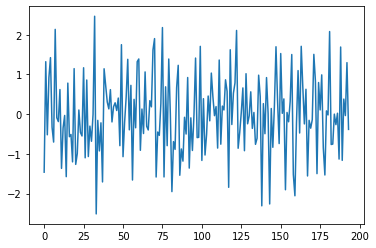

In [4]:
plt.plot(df_gazelines.index, df_gazelines['9000'])

# Make an object with eye poisitions on gazelines runs

In [5]:
positions = []
for i in range(n_eye_positions):
    a = i +1
    b = i +1
    positions.append(a)
    positions.append(b)
positions_reverse = sorted(positions, reverse=True)

positions_0 = np.concatenate((positions,positions_reverse[2:]))
gazelines_position = np.concatenate((positions_0,positions_0[2:]))

In [6]:
gazelines_position

array([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
       18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24,
       24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16,
       15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,
        7,  6,  6,  5,  5,  4,  4,  3,  3,  2,  2,  1,  1,  2,  2,  3,  3,
        4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12,
       12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24, 24, 23, 23, 22, 22, 21,
       21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13,
       12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,  7,  6,  6,  5,  5,  4,
        4,  3,  3,  2,  2,  1,  1])

# check how many time each position is fixe

In [7]:
valeurs_uniques, comptages = np.unique(gazelines_position, return_counts=True)

In [8]:
print(valeurs_uniques)
print(comptages)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4]


position 1 and 25 are note fixed with the same number of the others, we will exluded them 

# make a final array 


In [9]:
# make a data frame excluding position 1 and 25 
a = df_gazelines
a.index = gazelines_position
df_sorted = a.sort_index()
df = df_sorted.drop(index=[1,25])

In [10]:
positions = np.arange(2,25)
positions_to_keep = [2,5,20,24]

In [11]:
# make an empty final array with de good dimentions 
n_positions = 23 - len(positions_to_keep)
n_repetition = 8 
n_voxel = df.shape[1]
final_array = np.empty((n_voxel,n_repetition, n_positions))

In [12]:
final_array.shape

(9460, 8, 19)

In [13]:
# feel the final array 
a = 0 
for t,position in enumerate(positions) :
    if position not in positions_to_keep :
        a = a + 1  
        row  = df.loc[df.index == int(position)].T
        final_array[:, :,a-1 ] = row.values

In [14]:
final_array.shape

(9460, 8, 19)

### Vérifier le passage en 3D

In [15]:
a = df.loc[df.index == 3].T

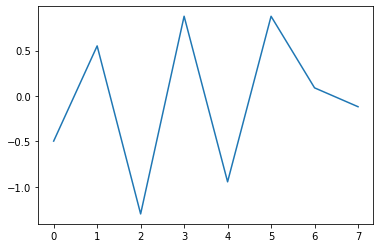

In [16]:
plt.plot(a.iloc[0, :].values)  # Tracer la première ligne de "a"
plt.show()

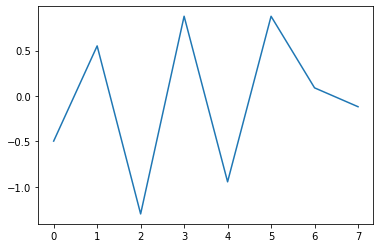

In [17]:
plt.plot(final_array[0,:,0])

# Machine Learning

étapes : <br>
garder 4 positions <br>
refaire matrice <br>
boucler sur les arbre qui ne voient quune position [:,:,t] <br>
mettre le gread search avec refit = True (défaut) <br>
stocker le meilleur model dans dictionaire (Hs.best_estimator_) <br>
fair une fonction qui récupère ça <br>


premier : insgancier le modèle avant la boucle 
ou optimiser pour chacun 

In [103]:
n_voxels = final_array.shape[0]

# make train labels
labels_train = np.zeros(n_positions)
a = 0
for t,position in enumerate(positions) :
    if position not in positions_to_keep :
        a = a + 1
        labels_train[a-1]= position
        
labels_train = labels_train.reshape(1,19)
labels_train = np.tile(labels_train, (n_voxels,1))

In [104]:
# make test labels
n_positions_to_keep = len(positions_to_keep)
labels_test = np.zeros(n_positions_to_keep)
a = 0
for t,position in enumerate(positions_to_keep) :
    a = a + 1
    labels_test[a-1]= position
        
labels_test = labels_test.reshape(1,n_positions_to_keep)
labels_test = np.tile(labels_test, (n_voxels,1))

In [105]:
# make test features
n_repetition = 8 
n_voxel = df.shape[1]
features_test = np.empty((n_voxel,n_repetition, n_positions_to_keep))

a = 0 
for t,position in enumerate(positions_to_keep) :
        a = a + 1  
        row  = df.loc[df.index == int(position)].T
        features_test[:, :,a-1 ] = row.values

In [74]:
features_test.shape

(9460, 8, 4)

In [106]:
# make train features
features_train = final_array.copy()

In [107]:
# defind param for GridSearchCV
param_grid = {
"max_depth": (2,3,4),
"min_samples_split": [1,2,3]
 }

In [108]:
model_num = []
for t in range(n_positions) : 
    model_num.append(t)
    

In [109]:
model_num

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [123]:
### in worging 
model_num = []
model_perf = []

for t in range(n_positions):
    model = DecisionTreeClassifier(random_state=42)
    search = GridSearchCV(model, param_grid, refit=True, cv=5)
    search.fit(features_train[:,:,t], labels_train[:,t])    
    model_num.append(t)
    model_perf.append(search)


In [128]:
n_models = len(model_perf)
predictions = []
for p in range(n_positions_to_keep):
    for t in range(n_models):
        prediction = model_perf[t].best_estimator_.predict(features_test[:,:,p])
        predictions.append(prediction)

In [132]:
np.shape(predictions)

(76, 9460)

In [133]:
predictions

[array([3., 3., 3., ..., 3., 3., 3.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([6., 6., 6., ..., 6., 6., 6.]),
 array([7., 7., 7., ..., 7., 7., 7.]),
 array([8., 8., 8., ..., 8., 8., 8.]),
 array([9., 9., 9., ..., 9., 9., 9.]),
 array([10., 10., 10., ..., 10., 10., 10.]),
 array([11., 11., 11., ..., 11., 11., 11.]),
 array([12., 12., 12., ..., 12., 12., 12.]),
 array([13., 13., 13., ..., 13., 13., 13.]),
 array([14., 14., 14., ..., 14., 14., 14.]),
 array([15., 15., 15., ..., 15., 15., 15.]),
 array([16., 16., 16., ..., 16., 16., 16.]),
 array([17., 17., 17., ..., 17., 17., 17.]),
 array([18., 18., 18., ..., 18., 18., 18.]),
 array([19., 19., 19., ..., 19., 19., 19.]),
 array([21., 21., 21., ..., 21., 21., 21.]),
 array([22., 22., 22., ..., 22., 22., 22.]),
 array([23., 23., 23., ..., 23., 23., 23.]),
 array([3., 3., 3., ..., 3., 3., 3.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([6., 6., 6., ..., 6., 6., 6.]),
 array([7., 7., 7., ..., 7., 7., 7.]),
 array([8., 8., 8., ..., 

In [101]:
labels_test[:,0]

TypeError: list indices must be integers or slices, not tuple

In [135]:
a = pd.DataFrame(features_test[:,:,0])

In [136]:
a

,0,1,2,3,4,5,6,7
0,-0.496011,0.550843,-1.296849,0.877117,-0.943848,0.876697,0.089645,-0.117923
1,-1.061846,0.246112,-1.665388,0.888193,0.559954,0.701375,-0.320573,-0.513307
2,0.027573,-0.235944,-0.021599,1.439189,-0.048829,-0.062012,-1.309352,-0.450937
3,-0.319400,-0.593739,0.805894,1.087462,0.773593,-0.542020,-0.970992,0.673304
4,0.776956,-0.760807,0.439365,0.978198,-0.377167,-0.427940,-0.368429,1.102664
...,...,...,...,...,...,...,...,...
9455,1.309315,-1.767713,0.443683,-0.277798,-1.270638,-0.633278,-0.212623,1.424433
9456,0.564130,-1.296163,1.345406,-0.484259,-0.568584,-2.173164,-0.512506,1.955715
9457,0.489265,0.119034,0.618402,-0.366231,-0.487407,-1.472224,1.083649,0.849287
9458,-0.268859,1.254576,0.596598,0.962385,-0.743644,1.656433,-0.402935,-0.573138


In [57]:
model = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(model, param_grid, refit=True, cv=5)
search.fit(features_train[:,:,0], labels_train[:,0])

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': (2, 3, 4),
                         'min_samples_split': [1, 2, 3]})

In [58]:
search.best_score_

1.0

In [53]:
labels_train[:,0].shape

(9460,)

# Brouillon

In [17]:
array = np.array(df.T)

In [18]:
array = array.reshape(8,9460,23)

In [19]:
print(array[:,0,0])

[ 0.0681677   0.73878426 -1.63491602  0.39837027 -0.02874917  0.52425134
  0.48090233  0.53018561]


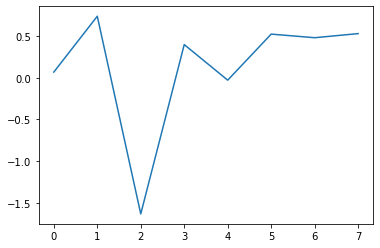

In [20]:
plt.plot(array[:,0,0])

# KNN

In [21]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

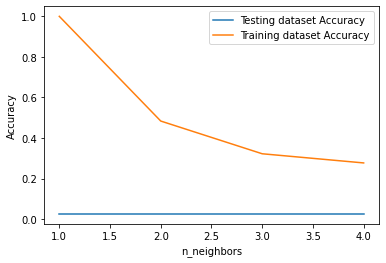

In [22]:



features_train0, features_test0, labels_train0, labels_test0 = train_test_split( 
              features, labels, test_size = 0.2, random_state=42) 

neighbors = np.arange(1, 5) 
  
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(features_train0, labels_train0) 
      
    
    train_accuracy[i] = knn.score(features_train0, labels_train0) 
    test_accuracy[i] = knn.score(features_test0, labels_test0) 
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show()

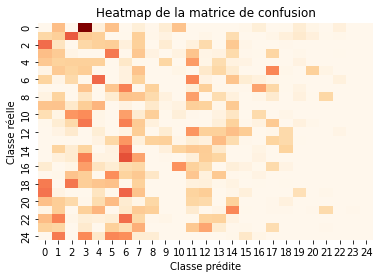

In [23]:
prediction_allrun=[]
labels_allrun=[]
for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split(features,labels, test_size=0.20, random_state=run)
    #features_train, features_test, labels_train, labels_test = train_test_split( random_features,random_labels, test_size=0.20, random_state=run)

    
    
    knn = KNeighborsClassifier(n_neighbors = 2).fit(features_train, labels_train)
    #accuracy = knn.score(features_train, labels_train)
    #print("Précision entrainement:", accuracy)
    
    pred_pop=knn.predict(features_test)
    
    # print(knn.predict(features_test))
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()




# Bayesian

In [24]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

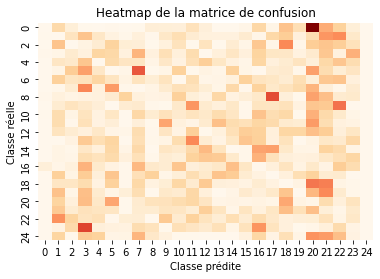

In [25]:

prediction_allrun=[]
labels_allrun=[]

for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    gnb = GaussianNB()

    pred_pop = gnb.fit(features_train, labels_train).predict(features_test)

    
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()



In [26]:
features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

model = GaussianNB()

model.fit(features_train, labels_train)

model.score(features_test,labels_test)

0.0

In [27]:
n_neighbors = np.arange(1, 100) 

score =[]
for i, n_neighbor in enumerate(n_neighbors):
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    model2 = KNeighborsClassifier(n_neighbors = n_neighbor).fit(features_train, labels_train)

    model2.fit(features_train, labels_train)

    a = model2.score(features_test,labels_test)
    score.append(a)

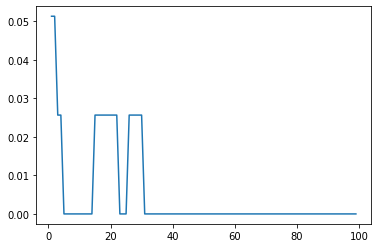

In [28]:
plt.plot(n_neighbors,score)

In [29]:
from sklearn.svm import LinearSVC

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Entraînement du modèle sur le train set
model.fit(features_train, labels_train)

# Évaluation de la performance du modèle sur le test set
accuracy = model.score(features_test, labels_test)
print("Précision du modèle : {:.2f}".format(accuracy))

Précision du modèle : 0.05


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Supposons que vous ayez déjà les données features et labels

# Split des données en train et test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Définition de la grille des hyperparamètres à explorer
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Valeurs de l'hyperparamètre C à explorer
    'penalty': ['l1', 'l2'],       # Méthode de régularisation (l1 ou l2)
    'dual': [False],               # Paramètre spécifique de LinearSVC (défini sur False pour des problèmes non duaux)
}

# Recherche des meilleures combinaisons d'hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv = nombre de folds pour la validation croisée

# Entraînement du modèle avec la recherche des hyperparamètres
grid_search.fit(features_train, labels_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Évaluation de la performance du modèle avec les meilleurs hyperparamètres sur le test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(features_test, labels_test)
print("Précision du modèle avec les meilleurs hyperparamètres : {:.2f}".format(accuracy))


In [ ]:
model = NomDuModele(parametres,hypermarametres)
model.fit(X_train,y_train) # apprentissage supervisé
model.fit(X_train)

In [1]:
# General import 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random 

# Stop warnings
import warnings
warnings.filterwarnings("ignore")

#sklearn import
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB

# figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns


# Parameters and import data

In [2]:
# parameters
n_eye_positions = 25
subject = 'sub-001'

# defind data directory 
project_dir = '/home/ulascombes/disks/meso_shared/gaze_exp'
pp_dir = '{}/derivatives/pp_data'.format(project_dir)
df_fn = "{}/{}/desu".format(pp_dir,subject)

# tsv names
df_name_GazeLines ='df_task_GazeLines_runs.tsv'
df_name_GazeColumns ='df_task_GazeColumns_runs.tsv'

# import datas 
df_gazelines =pd.read_table('{}/{}'.format(df_fn,df_name_GazeLines))
df_gazecolumns =pd.read_table('{}/{}'.format(df_fn,df_name_GazeColumns))

### drop 3 first TRs
df_gazelines = df_gazelines.drop(df_gazelines.index[:3]).reset_index(drop=True)
df_gazecolumns = df_gazecolumns.drop(df_gazecolumns.index[:3]).reset_index(drop=True)

In [3]:
df_gazelines.shape

(194, 9460)

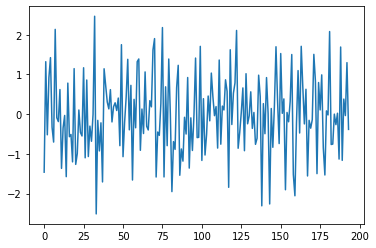

In [4]:
plt.plot(df_gazelines.index, df_gazelines['9000'])

# Make an object with eye poisitions on gazelines runs

In [3]:
positions = []
for i in range(n_eye_positions):
    a = i +1
    b = i +1
    positions.append(a)
    positions.append(b)
positions_reverse = sorted(positions, reverse=True)

positions_0 = np.concatenate((positions,positions_reverse[2:]))
gazelines_position = np.concatenate((positions_0,positions_0[2:]))

In [6]:
gazelines_position

array([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
       18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24,
       24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16,
       15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,
        7,  6,  6,  5,  5,  4,  4,  3,  3,  2,  2,  1,  1,  2,  2,  3,  3,
        4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12,
       12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24, 24, 23, 23, 22, 22, 21,
       21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13,
       12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,  7,  6,  6,  5,  5,  4,
        4,  3,  3,  2,  2,  1,  1])

# check how many time each position is fixe

In [4]:
valeurs_uniques, comptages = np.unique(gazelines_position, return_counts=True)

In [5]:
print(valeurs_uniques)
print(comptages)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4]


position 1 and 25 are note fixed with the same number of the others, we will exluded them 

# make a final array 


In [6]:
# make a data frame excluding position 1 and 25 
a = df_gazelines
a.index = gazelines_position
df_sorted = a.sort_index()
df = df_sorted.drop(index=[1,25])

In [9]:
df_gazelines

,0,1,2,3,4,5,6,7,8,9,...,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459
1,0.083006,-0.617929,-1.597409,-1.983534,-2.031179,-0.646076,-1.069582,0.080500,0.715909,-1.376895,...,-2.070088,-1.017910,0.788270,-0.294448,-1.099909,0.786997,-0.483914,-0.669404,1.156783,1.057327
1,0.938530,1.552278,1.439985,1.305903,0.793467,1.300097,1.217656,0.761341,0.478927,0.742067,...,0.041951,1.913351,0.164950,-0.329909,0.220296,-0.342339,-0.283261,-0.055313,0.764603,0.840576
2,-1.720407,-1.425911,-0.738143,-1.152015,-0.092956,-0.784059,1.651651,0.323650,0.231620,0.750255,...,-0.815439,-1.117031,0.791771,-0.459010,-0.557289,1.557394,0.598023,0.454054,-0.165932,-0.529197
2,0.358119,-0.043660,0.512135,0.140024,-0.192965,0.825972,-0.697522,0.392435,0.613556,-0.987082,...,-1.387696,0.191658,1.410546,-1.409461,-1.326319,-0.839005,-0.013280,0.822457,0.165634,-0.445030
3,-0.496011,-1.061846,0.027573,-0.319400,0.776956,-1.402118,-0.174105,-1.085887,-0.879494,0.252444,...,-0.147992,-2.194724,-0.027457,-0.745434,-0.845318,1.309315,0.564130,0.489265,-0.268859,0.726584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-1.296849,-1.665388,-0.021599,0.805894,0.439365,-0.303092,-0.107220,-0.881265,-1.810711,-1.294774,...,-1.882508,0.350960,1.265393,-1.633626,-1.714578,0.443683,1.345406,0.618402,0.596598,1.577908
2,1.238493,0.907131,1.188677,-0.280647,0.934426,1.372460,1.215242,1.648377,1.148051,0.602244,...,-1.053527,-0.042869,-0.065556,-0.566154,0.145714,1.892501,1.791316,2.730474,-0.874001,-1.238464
2,0.068168,0.131803,-0.762264,-1.335223,-0.786031,-0.189011,-1.080037,-0.142267,-0.050424,-0.385406,...,-1.464494,0.100315,0.826983,-0.010035,-0.729488,0.630989,-0.243904,0.209710,1.922080,-0.102288
1,-0.601131,0.550640,0.953258,-0.205744,-0.490364,0.436180,0.528580,0.367558,0.335447,1.004832,...,-1.733947,-0.345141,1.087351,0.738624,-0.572632,0.457343,1.180767,0.507278,0.301826,1.784685


In [10]:
# make an empty final array with de good dimentions 
n_positions = 23
n_repetition = 8 
n_voxel = df.shape[1]
final_array = np.empty((n_voxel,n_repetition, n_positions))

In [11]:
final_array.shape

(9460, 8, 23)

In [12]:
# feel the final array 
positions = np.arange(2,25)
for t,position in enumerate(positions) :
    row  = df.loc[df.index == int(position)].T
    final_array[:, :,t ] = row.values

In [13]:
final_array.shape

(9460, 8, 23)

### Vérifier

In [14]:
a = df.loc[df.index == 24].T

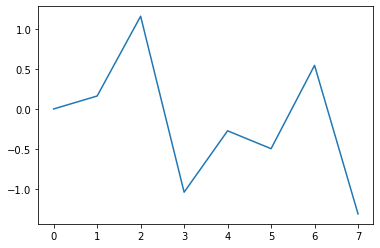

In [15]:
plt.plot(a.iloc[0, :].values)  # Tracer la première ligne de "a"
plt.show()

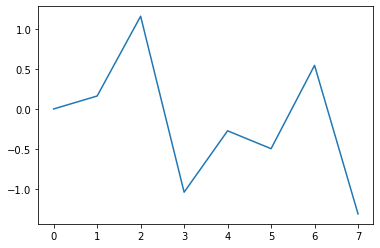

In [16]:
plt.plot(final_array[0,:,-1])

# Brouillon

In [17]:
array = np.array(df.T)

In [18]:
array = array.reshape(8,9460,23)

In [19]:
print(array[:,0,0])

[ 0.0681677   0.73878426 -1.63491602  0.39837027 -0.02874917  0.52425134
  0.48090233  0.53018561]


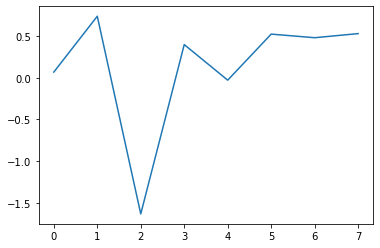

In [20]:
plt.plot(array[:,0,0])

étapes : 
garder 4 positions 
refaire matrice 
boucler sur les arbre qui ne voient quune position [:,:,t]
mettre le gread search avec refit = True (défaut)
stocker le meilleur model dans dictionaire (Hs.best_estimator_)
fair une fonction qui récupère ça 


In [ ]:
premier : insgancier le modèle avant la boucle 
ou optimiser pour chacun 

# KNN

In [21]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

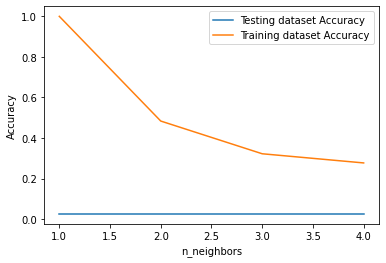

In [22]:



features_train0, features_test0, labels_train0, labels_test0 = train_test_split( 
              features, labels, test_size = 0.2, random_state=42) 

neighbors = np.arange(1, 5) 
  
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(features_train0, labels_train0) 
      
    
    train_accuracy[i] = knn.score(features_train0, labels_train0) 
    test_accuracy[i] = knn.score(features_test0, labels_test0) 
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show()

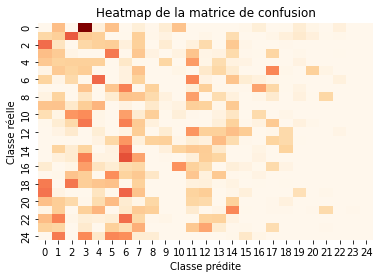

In [23]:
prediction_allrun=[]
labels_allrun=[]
for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split(features,labels, test_size=0.20, random_state=run)
    #features_train, features_test, labels_train, labels_test = train_test_split( random_features,random_labels, test_size=0.20, random_state=run)

    
    
    knn = KNeighborsClassifier(n_neighbors = 2).fit(features_train, labels_train)
    #accuracy = knn.score(features_train, labels_train)
    #print("Précision entrainement:", accuracy)
    
    pred_pop=knn.predict(features_test)
    
    # print(knn.predict(features_test))
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()




# Bayesian

In [24]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

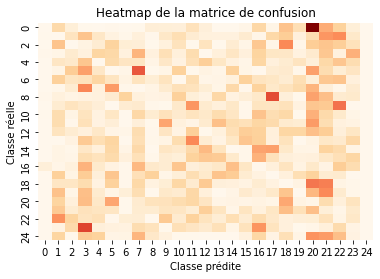

In [25]:

prediction_allrun=[]
labels_allrun=[]

for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    gnb = GaussianNB()

    pred_pop = gnb.fit(features_train, labels_train).predict(features_test)

    
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()



In [26]:
features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

model = GaussianNB()

model.fit(features_train, labels_train)

model.score(features_test,labels_test)

0.0

In [27]:
n_neighbors = np.arange(1, 100) 

score =[]
for i, n_neighbor in enumerate(n_neighbors):
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    model2 = KNeighborsClassifier(n_neighbors = n_neighbor).fit(features_train, labels_train)

    model2.fit(features_train, labels_train)

    a = model2.score(features_test,labels_test)
    score.append(a)

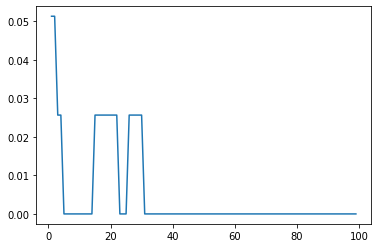

In [28]:
plt.plot(n_neighbors,score)

In [29]:
from sklearn.svm import LinearSVC

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Entraînement du modèle sur le train set
model.fit(features_train, labels_train)

# Évaluation de la performance du modèle sur le test set
accuracy = model.score(features_test, labels_test)
print("Précision du modèle : {:.2f}".format(accuracy))

Précision du modèle : 0.05


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Supposons que vous ayez déjà les données features et labels

# Split des données en train et test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Définition de la grille des hyperparamètres à explorer
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Valeurs de l'hyperparamètre C à explorer
    'penalty': ['l1', 'l2'],       # Méthode de régularisation (l1 ou l2)
    'dual': [False],               # Paramètre spécifique de LinearSVC (défini sur False pour des problèmes non duaux)
}

# Recherche des meilleures combinaisons d'hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv = nombre de folds pour la validation croisée

# Entraînement du modèle avec la recherche des hyperparamètres
grid_search.fit(features_train, labels_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Évaluation de la performance du modèle avec les meilleurs hyperparamètres sur le test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(features_test, labels_test)
print("Précision du modèle avec les meilleurs hyperparamètres : {:.2f}".format(accuracy))


In [ ]:
model = NomDuModele(parametres,hypermarametres)
model.fit(X_train,y_train) # apprentissage supervisé
model.fit(X_train)

In [129]:
# General import 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random 

# Stop warnings
import warnings
warnings.filterwarnings("ignore")

#sklearn import
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV



# figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns


# Parameters and import data

In [2]:
# parameters
n_eye_positions = 25
subject = 'sub-001'

# defind data directory 
project_dir = '/home/ulascombes/disks/meso_shared/gaze_exp'
pp_dir = '{}/derivatives/pp_data'.format(project_dir)
df_fn = "{}/{}/desu".format(pp_dir,subject)

# tsv names
df_name_GazeLines ='df_task_GazeLines_runs.tsv'
df_name_GazeColumns ='df_task_GazeColumns_runs.tsv'

# import datas 
df_gazelines =pd.read_table('{}/{}'.format(df_fn,df_name_GazeLines))
df_gazecolumns =pd.read_table('{}/{}'.format(df_fn,df_name_GazeColumns))

### drop 3 first TRs
df_gazelines = df_gazelines.drop(df_gazelines.index[:3]).reset_index(drop=True)
df_gazecolumns = df_gazecolumns.drop(df_gazecolumns.index[:3]).reset_index(drop=True)

In [3]:
df_gazelines.shape

(194, 9460)

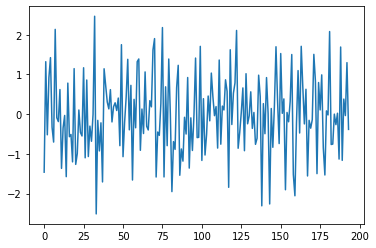

In [4]:
plt.plot(df_gazelines.index, df_gazelines['9000'])

# Make an object with eye poisitions on gazelines runs

In [5]:
positions = []
for i in range(n_eye_positions):
    a = i +1
    b = i +1
    positions.append(a)
    positions.append(b)
positions_reverse = sorted(positions, reverse=True)

positions_0 = np.concatenate((positions,positions_reverse[2:]))
gazelines_position = np.concatenate((positions_0,positions_0[2:]))

In [6]:
gazelines_position

array([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
       18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24,
       24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16,
       15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,
        7,  6,  6,  5,  5,  4,  4,  3,  3,  2,  2,  1,  1,  2,  2,  3,  3,
        4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12,
       12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24, 24, 23, 23, 22, 22, 21,
       21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13,
       12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,  7,  6,  6,  5,  5,  4,
        4,  3,  3,  2,  2,  1,  1])

# check how many time each position is fixe

In [7]:
valeurs_uniques, comptages = np.unique(gazelines_position, return_counts=True)

In [8]:
print(valeurs_uniques)
print(comptages)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4]


position 1 and 25 are note fixed with the same number of the others, we will exluded them 

# make a final array 


In [9]:
# make a data frame excluding position 1 and 25 
a = df_gazelines
a.index = gazelines_position
df_sorted = a.sort_index()
df = df_sorted.drop(index=[1,25])

In [10]:
positions = np.arange(2,25)
positions_to_keep = [2,5,20,24]

In [11]:
# make an empty final array with de good dimentions 
n_positions = 23 - len(positions_to_keep)
n_repetition = 8 
n_voxel = df.shape[1]
final_array = np.empty((n_voxel,n_repetition, n_positions))

In [30]:
final_array.shape

(9460, 8, 19)

In [20]:
# feel the final array 
a = 0 
for t,position in enumerate(positions) :
    if position not in positions_to_keep :
        a = a + 1  
        row  = df.loc[df.index == int(position)].T
        final_array[:, :,a-1 ] = row.values

In [21]:
final_array.shape

(9460, 8, 19)

### Vérifier le passage en 3D

In [33]:
a = df.loc[df.index == 3].T

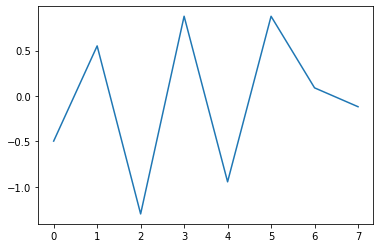

In [34]:
plt.plot(a.iloc[0, :].values)  # Tracer la première ligne de "a"
plt.show()

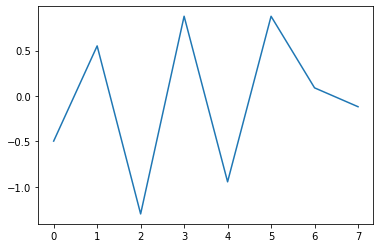

In [35]:
plt.plot(final_array[0,:,0])

# Machine Learning

étapes : <br>
garder 4 positions <br>
refaire matrice <br>
boucler sur les arbre qui ne voient quune position [:,:,t] <br>
mettre le gread search avec refit = True (défaut) <br>
stocker le meilleur model dans dictionaire (Hs.best_estimator_) <br>
fair une fonction qui récupère ça <br>


premier : insgancier le modèle avant la boucle 
ou optimiser pour chacun 

In [91]:
# make train labels
labels_train = np.zeros(n_positions)
a = 0
for t,position in enumerate(positions) :
    if position not in positions_to_keep :
        a = a + 1
        labels_train[a-1]= position

In [96]:
# make test labels
labels_test = positions_to_keep.copy()

In [98]:
# make train features
features_test = final_array.copy()

In [100]:
# defind param for GridSearchCV
param_grid = {
"max_depth": (2,3,4),
"min_samples_split": [1,2,3]
 }

In [126]:
model_num = []
for t in range(n_positions) : 
    model_num.append(t)
    

In [127]:
model_num

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
### in worging 
model_num = []
model_perf = []

for t in range(n_positions):
    model = DecisionTreeClassifier(random_state=42)
    search = GridSearchCV(model, param_grid, refit=True, cv=5)
    search.fit(features_test[:,:,t], labels_test)
    
    model_num.append(t)
    model_perf.append(search)


In [135]:
a = pd.DataFrame(features_test[:,:,0])

In [136]:
a

,0,1,2,3,4,5,6,7
0,-0.496011,0.550843,-1.296849,0.877117,-0.943848,0.876697,0.089645,-0.117923
1,-1.061846,0.246112,-1.665388,0.888193,0.559954,0.701375,-0.320573,-0.513307
2,0.027573,-0.235944,-0.021599,1.439189,-0.048829,-0.062012,-1.309352,-0.450937
3,-0.319400,-0.593739,0.805894,1.087462,0.773593,-0.542020,-0.970992,0.673304
4,0.776956,-0.760807,0.439365,0.978198,-0.377167,-0.427940,-0.368429,1.102664
...,...,...,...,...,...,...,...,...
9455,1.309315,-1.767713,0.443683,-0.277798,-1.270638,-0.633278,-0.212623,1.424433
9456,0.564130,-1.296163,1.345406,-0.484259,-0.568584,-2.173164,-0.512506,1.955715
9457,0.489265,0.119034,0.618402,-0.366231,-0.487407,-1.472224,1.083649,0.849287
9458,-0.268859,1.254576,0.596598,0.962385,-0.743644,1.656433,-0.402935,-0.573138


In [138]:
model = DecisionTreeClassifier(random_state=42)
search = GridSearchCV(model, param_grid, refit=True, cv=5)
search.fit(features_test[:,:,0], labels_test)

ValueError: Found input variables with inconsistent numbers of samples: [9460, 4]

# Brouillon

In [17]:
array = np.array(df.T)

In [18]:
array = array.reshape(8,9460,23)

In [19]:
print(array[:,0,0])

[ 0.0681677   0.73878426 -1.63491602  0.39837027 -0.02874917  0.52425134
  0.48090233  0.53018561]


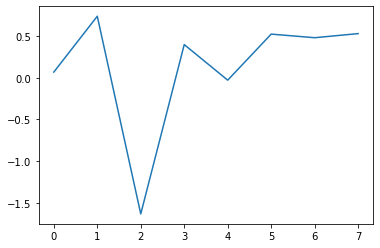

In [20]:
plt.plot(array[:,0,0])

# KNN

In [21]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

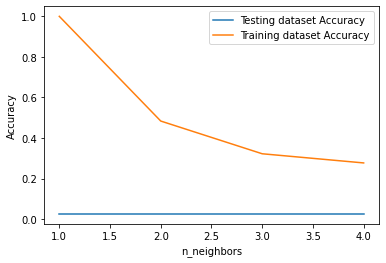

In [22]:



features_train0, features_test0, labels_train0, labels_test0 = train_test_split( 
              features, labels, test_size = 0.2, random_state=42) 

neighbors = np.arange(1, 5) 
  
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(features_train0, labels_train0) 
      
    
    train_accuracy[i] = knn.score(features_train0, labels_train0) 
    test_accuracy[i] = knn.score(features_test0, labels_test0) 
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show()

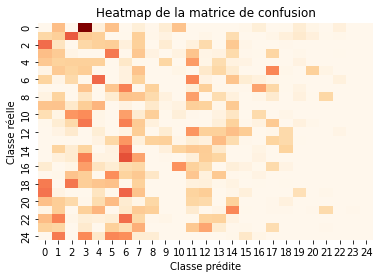

In [23]:
prediction_allrun=[]
labels_allrun=[]
for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split(features,labels, test_size=0.20, random_state=run)
    #features_train, features_test, labels_train, labels_test = train_test_split( random_features,random_labels, test_size=0.20, random_state=run)

    
    
    knn = KNeighborsClassifier(n_neighbors = 2).fit(features_train, labels_train)
    #accuracy = knn.score(features_train, labels_train)
    #print("Précision entrainement:", accuracy)
    
    pred_pop=knn.predict(features_test)
    
    # print(knn.predict(features_test))
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()




# Bayesian

In [24]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

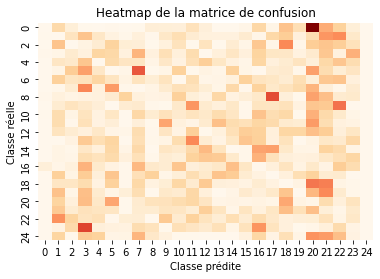

In [25]:

prediction_allrun=[]
labels_allrun=[]

for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    gnb = GaussianNB()

    pred_pop = gnb.fit(features_train, labels_train).predict(features_test)

    
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()



In [26]:
features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

model = GaussianNB()

model.fit(features_train, labels_train)

model.score(features_test,labels_test)

0.0

In [27]:
n_neighbors = np.arange(1, 100) 

score =[]
for i, n_neighbor in enumerate(n_neighbors):
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    model2 = KNeighborsClassifier(n_neighbors = n_neighbor).fit(features_train, labels_train)

    model2.fit(features_train, labels_train)

    a = model2.score(features_test,labels_test)
    score.append(a)

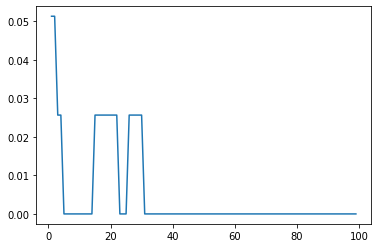

In [28]:
plt.plot(n_neighbors,score)

In [29]:
from sklearn.svm import LinearSVC

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Entraînement du modèle sur le train set
model.fit(features_train, labels_train)

# Évaluation de la performance du modèle sur le test set
accuracy = model.score(features_test, labels_test)
print("Précision du modèle : {:.2f}".format(accuracy))

Précision du modèle : 0.05


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Supposons que vous ayez déjà les données features et labels

# Split des données en train et test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Définition de la grille des hyperparamètres à explorer
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Valeurs de l'hyperparamètre C à explorer
    'penalty': ['l1', 'l2'],       # Méthode de régularisation (l1 ou l2)
    'dual': [False],               # Paramètre spécifique de LinearSVC (défini sur False pour des problèmes non duaux)
}

# Recherche des meilleures combinaisons d'hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv = nombre de folds pour la validation croisée

# Entraînement du modèle avec la recherche des hyperparamètres
grid_search.fit(features_train, labels_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Évaluation de la performance du modèle avec les meilleurs hyperparamètres sur le test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(features_test, labels_test)
print("Précision du modèle avec les meilleurs hyperparamètres : {:.2f}".format(accuracy))


In [ ]:
model = NomDuModele(parametres,hypermarametres)
model.fit(X_train,y_train) # apprentissage supervisé
model.fit(X_train)

In [1]:
# General import 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random 

# Stop warnings
import warnings
warnings.filterwarnings("ignore")

#sklearn import
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB

# figure imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns


# Parameters and import data

In [2]:
# parameters
n_eye_positions = 25
subject = 'sub-001'

# defind data directory 
project_dir = '/home/ulascombes/disks/meso_shared/gaze_exp'
pp_dir = '{}/derivatives/pp_data'.format(project_dir)
df_fn = "{}/{}/desu".format(pp_dir,subject)

# tsv names
df_name_GazeLines ='df_task_GazeLines_runs.tsv'
df_name_GazeColumns ='df_task_GazeColumns_runs.tsv'

# import datas 
df_gazelines =pd.read_table('{}/{}'.format(df_fn,df_name_GazeLines))
df_gazecolumns =pd.read_table('{}/{}'.format(df_fn,df_name_GazeColumns))

### drop 3 first TRs
df_gazelines = df_gazelines.drop(df_gazelines.index[:3]).reset_index(drop=True)
df_gazecolumns = df_gazecolumns.drop(df_gazecolumns.index[:3]).reset_index(drop=True)

In [3]:
df_gazelines.shape

(194, 9460)

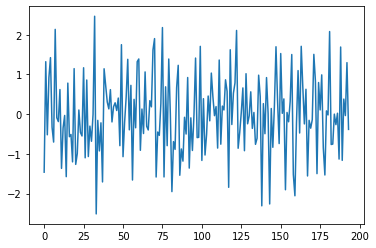

In [4]:
plt.plot(df_gazelines.index, df_gazelines['9000'])

# Make an object with eye poisitions on gazelines runs

In [3]:
positions = []
for i in range(n_eye_positions):
    a = i +1
    b = i +1
    positions.append(a)
    positions.append(b)
positions_reverse = sorted(positions, reverse=True)

positions_0 = np.concatenate((positions,positions_reverse[2:]))
gazelines_position = np.concatenate((positions_0,positions_0[2:]))

In [6]:
gazelines_position

array([ 1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
        9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
       18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24,
       24, 23, 23, 22, 22, 21, 21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16,
       15, 15, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,
        7,  6,  6,  5,  5,  4,  4,  3,  3,  2,  2,  1,  1,  2,  2,  3,  3,
        4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12,
       12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 24, 24, 23, 23, 22, 22, 21,
       21, 20, 20, 19, 19, 18, 18, 17, 17, 16, 16, 15, 15, 14, 14, 13, 13,
       12, 12, 11, 11, 10, 10,  9,  9,  8,  8,  7,  7,  6,  6,  5,  5,  4,
        4,  3,  3,  2,  2,  1,  1])

# check how many time each position is fixe

In [4]:
valeurs_uniques, comptages = np.unique(gazelines_position, return_counts=True)

In [5]:
print(valeurs_uniques)
print(comptages)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[6 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 4]


position 1 and 25 are note fixed with the same number of the others, we will exluded them 

# make a final array 


In [6]:
# make a data frame excluding position 1 and 25 
a = df_gazelines
a.index = gazelines_position
df_sorted = a.sort_index()
df = df_sorted.drop(index=[1,25])

In [9]:
df_gazelines

,0,1,2,3,4,5,6,7,8,9,...,9450,9451,9452,9453,9454,9455,9456,9457,9458,9459
1,0.083006,-0.617929,-1.597409,-1.983534,-2.031179,-0.646076,-1.069582,0.080500,0.715909,-1.376895,...,-2.070088,-1.017910,0.788270,-0.294448,-1.099909,0.786997,-0.483914,-0.669404,1.156783,1.057327
1,0.938530,1.552278,1.439985,1.305903,0.793467,1.300097,1.217656,0.761341,0.478927,0.742067,...,0.041951,1.913351,0.164950,-0.329909,0.220296,-0.342339,-0.283261,-0.055313,0.764603,0.840576
2,-1.720407,-1.425911,-0.738143,-1.152015,-0.092956,-0.784059,1.651651,0.323650,0.231620,0.750255,...,-0.815439,-1.117031,0.791771,-0.459010,-0.557289,1.557394,0.598023,0.454054,-0.165932,-0.529197
2,0.358119,-0.043660,0.512135,0.140024,-0.192965,0.825972,-0.697522,0.392435,0.613556,-0.987082,...,-1.387696,0.191658,1.410546,-1.409461,-1.326319,-0.839005,-0.013280,0.822457,0.165634,-0.445030
3,-0.496011,-1.061846,0.027573,-0.319400,0.776956,-1.402118,-0.174105,-1.085887,-0.879494,0.252444,...,-0.147992,-2.194724,-0.027457,-0.745434,-0.845318,1.309315,0.564130,0.489265,-0.268859,0.726584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,-1.296849,-1.665388,-0.021599,0.805894,0.439365,-0.303092,-0.107220,-0.881265,-1.810711,-1.294774,...,-1.882508,0.350960,1.265393,-1.633626,-1.714578,0.443683,1.345406,0.618402,0.596598,1.577908
2,1.238493,0.907131,1.188677,-0.280647,0.934426,1.372460,1.215242,1.648377,1.148051,0.602244,...,-1.053527,-0.042869,-0.065556,-0.566154,0.145714,1.892501,1.791316,2.730474,-0.874001,-1.238464
2,0.068168,0.131803,-0.762264,-1.335223,-0.786031,-0.189011,-1.080037,-0.142267,-0.050424,-0.385406,...,-1.464494,0.100315,0.826983,-0.010035,-0.729488,0.630989,-0.243904,0.209710,1.922080,-0.102288
1,-0.601131,0.550640,0.953258,-0.205744,-0.490364,0.436180,0.528580,0.367558,0.335447,1.004832,...,-1.733947,-0.345141,1.087351,0.738624,-0.572632,0.457343,1.180767,0.507278,0.301826,1.784685


In [10]:
# make an empty final array with de good dimentions 
n_positions = 23
n_repetition = 8 
n_voxel = df.shape[1]
final_array = np.empty((n_voxel,n_repetition, n_positions))

In [11]:
final_array.shape

(9460, 8, 23)

In [12]:
# feel the final array 
positions = np.arange(2,25)
for t,position in enumerate(positions) :
    row  = df.loc[df.index == int(position)].T
    final_array[:, :,t ] = row.values

In [13]:
final_array.shape

(9460, 8, 23)

### Vérifier

In [14]:
a = df.loc[df.index == 24].T

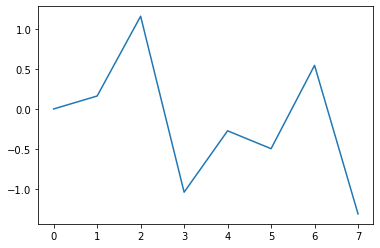

In [15]:
plt.plot(a.iloc[0, :].values)  # Tracer la première ligne de "a"
plt.show()

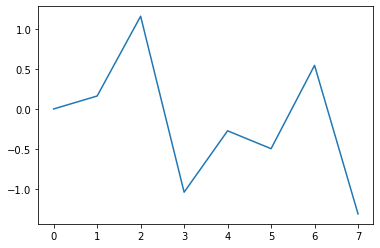

In [16]:
plt.plot(final_array[0,:,-1])

# Brouillon

In [17]:
array = np.array(df.T)

In [18]:
array = array.reshape(8,9460,23)

In [19]:
print(array[:,0,0])

[ 0.0681677   0.73878426 -1.63491602  0.39837027 -0.02874917  0.52425134
  0.48090233  0.53018561]


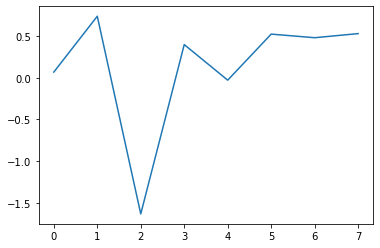

In [20]:
plt.plot(array[:,0,0])

étapes : 
garder 4 positions 
refaire matrice 
boucler sur les arbre qui ne voient quune position [:,:,t]
mettre le gread search avec refit = True (défaut)
stocker le meilleur model dans dictionaire (Hs.best_estimator_)
fair une fonction qui récupère ça 


In [ ]:
premier : insgancier le modèle avant la boucle 
ou optimiser pour chacun 

# KNN

In [21]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

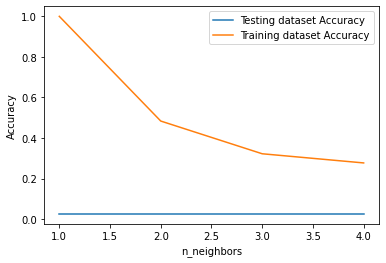

In [22]:



features_train0, features_test0, labels_train0, labels_test0 = train_test_split( 
              features, labels, test_size = 0.2, random_state=42) 

neighbors = np.arange(1, 5) 
  
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors)) 
  
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(features_train0, labels_train0) 
      
    
    train_accuracy[i] = knn.score(features_train0, labels_train0) 
    test_accuracy[i] = knn.score(features_test0, labels_test0) 
  
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show()

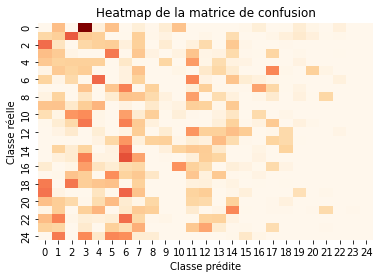

In [23]:
prediction_allrun=[]
labels_allrun=[]
for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split(features,labels, test_size=0.20, random_state=run)
    #features_train, features_test, labels_train, labels_test = train_test_split( random_features,random_labels, test_size=0.20, random_state=run)

    
    
    knn = KNeighborsClassifier(n_neighbors = 2).fit(features_train, labels_train)
    #accuracy = knn.score(features_train, labels_train)
    #print("Précision entrainement:", accuracy)
    
    pred_pop=knn.predict(features_test)
    
    # print(knn.predict(features_test))
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()




# Bayesian

In [24]:
features = np.array(df_gazelines)
labels = np.array(gazelines_position)

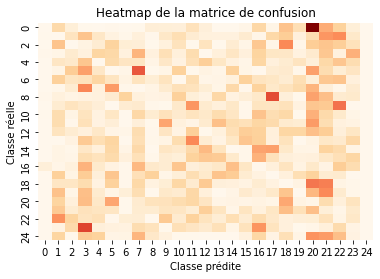

In [25]:

prediction_allrun=[]
labels_allrun=[]

for run in range(1000):
    
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    gnb = GaussianNB()

    pred_pop = gnb.fit(features_train, labels_train).predict(features_test)

    
    
    prediction_allrun.extend(pred_pop.tolist())    
    labels_allrun.extend(labels_test)    

cm = confusion_matrix(y_true=labels_allrun, y_pred=prediction_allrun, normalize='true')

# Afficher la heatmap de la matrice de confusion
sns.heatmap(cm, annot=False, cmap='OrRd', cbar=False)
plt.title('Heatmap de la matrice de confusion')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.show()



In [26]:
features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

model = GaussianNB()

model.fit(features_train, labels_train)

model.score(features_test,labels_test)

0.0

In [27]:
n_neighbors = np.arange(1, 100) 

score =[]
for i, n_neighbor in enumerate(n_neighbors):
    features_train, features_test, labels_train, labels_test = train_test_split( features,labels, test_size=0.20, random_state=run)

    model2 = KNeighborsClassifier(n_neighbors = n_neighbor).fit(features_train, labels_train)

    model2.fit(features_train, labels_train)

    a = model2.score(features_test,labels_test)
    score.append(a)

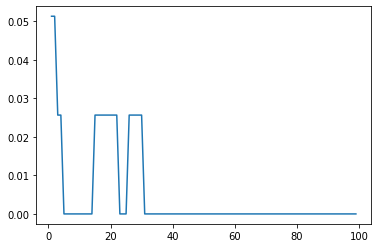

In [28]:
plt.plot(n_neighbors,score)

In [29]:
from sklearn.svm import LinearSVC

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Entraînement du modèle sur le train set
model.fit(features_train, labels_train)

# Évaluation de la performance du modèle sur le test set
accuracy = model.score(features_test, labels_test)
print("Précision du modèle : {:.2f}".format(accuracy))

Précision du modèle : 0.05


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Supposons que vous ayez déjà les données features et labels

# Split des données en train et test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=run)

# Initialisation du modèle LinearSVC
model = LinearSVC()

# Définition de la grille des hyperparamètres à explorer
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Valeurs de l'hyperparamètre C à explorer
    'penalty': ['l1', 'l2'],       # Méthode de régularisation (l1 ou l2)
    'dual': [False],               # Paramètre spécifique de LinearSVC (défini sur False pour des problèmes non duaux)
}

# Recherche des meilleures combinaisons d'hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv = nombre de folds pour la validation croisée

# Entraînement du modèle avec la recherche des hyperparamètres
grid_search.fit(features_train, labels_train)

# Affichage des meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Évaluation de la performance du modèle avec les meilleurs hyperparamètres sur le test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(features_test, labels_test)
print("Précision du modèle avec les meilleurs hyperparamètres : {:.2f}".format(accuracy))


In [ ]:
model = NomDuModele(parametres,hypermarametres)
model.fit(X_train,y_train) # apprentissage supervisé
model.fit(X_train)